# GraphNet Mk1

A Graph Neural Network to reconstruct event properties from pulses. This notebook processses the data, constructs the Neural Network architecture, fits the data, and then offers some ways to compare the performance to SPEFit.

In [165]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

### Load pulses

In [3]:
from IceNet.dataloader import get_pulses

In [4]:
labels = ['azimuth', 'zenith']

In [213]:
fstart = 161
n_files = 10
fend = fstart+n_files

In [214]:
fnames = ['oscNext_genie_level3_v01.03_pass2.140000.000%03i' % (i) for i in range(fstart, fend)]

In [215]:
def _read_files(file_list, labels):
    x, y = [], []
    corrupts = []
    for files in file_list:
        print(files)
        try:
            xx, yy = get_pulses('./input/'+files+'.hdf5', labels=labels)
            x.append(xx)
            y.append(yy)
        except:
            corrupts.append(files)
    flatten = lambda superlist: [x for sublist in superlist for x in sublist]
    x = flatten(x)
    y = flatten(y)
    if len(corrupts) != 0:
        print ('Files not read', corrupts)
    return x, y 

In [216]:
x, y = _read_files(fnames, labels)

oscNext_genie_level3_v01.03_pass2.140000.000161



oscNext_genie_level3_v01.03_pass2.140000.000162



oscNext_genie_level3_v01.03_pass2.140000.000163
oscNext_genie_level3_v01.03_pass2.140000.000164



oscNext_genie_level3_v01.03_pass2.140000.000165



oscNext_genie_level3_v01.03_pass2.140000.000166



oscNext_genie_level3_v01.03_pass2.140000.000167



oscNext_genie_level3_v01.03_pass2.140000.000168



oscNext_genie_level3_v01.03_pass2.140000.000169



oscNext_genie_level3_v01.03_pass2.140000.000170



Files not read ['oscNext_genie_level3_v01.03_pass2.140000.000163']


### Filter events with many pulses
The neural network connects each pulse to another, so the complexity scales with $O(n^2)$ with each pulse. This affects the calculation of the distance matrices, as well as the training of the network. To simplify, we limit the number of pulses. As this cut favors low-energy events, which our work focuses on,

### Filter energy

In [217]:
# Convert to cartesian if necessary
import math
def polar2cart(r, phi, theta):
    return [
         r * math.sin(theta) * math.cos(phi),
         r * math.sin(theta) * math.sin(phi),
         r * math.cos(theta)
    ]

In [218]:
max_pulses = 50
pulse_mask = [i for i, event in enumerate(x) if len(event) < max_pulses]

In [219]:
x_filtered = [x[i] for i in pulse_mask]
# y_filtered = [y[i] for i in pulse_mask]
# y_transformed = [[np.sin(y[i]), np.cos(y[i])] for i in pulse_mask] # In case of zenith angle
# y_filtered = [np.log10(y[i])for i in pulse_mask] # In case of energy
y_transformed = [polar2cart(1, *y[i]) for i in pulse_mask]

### Convert time to position

In [220]:
col_t = 1
c = 299792458 # mps

xt = np.copy(x_filtered)
time_to_pos = [event[:,col_t]*1e-9*c for event in xt]
time_to_pos = [time.reshape(-1, 1) for time in time_to_pos]

### Use DOM positional information

In [221]:
from IceNet.icecubeutils import get_dom_positions
dom_positions = get_dom_positions()

In [222]:
hit_doms = [dom_positions[event[:,0].astype(int)] for event in x_filtered]

### Join all positional information

In [223]:
all_pos = [np.concatenate((time, pos), axis=1) for time, pos in zip(time_to_pos, hit_doms)]

### Calculate distance matrices

In [224]:
def calc_dist_matrix(event):
    npulses = len(event)
    idx = np.asarray(list(np.ndindex((npulses, npulses))))
    calc_dist = lambda i, j: np.linalg.norm(event[i] - event[j]) \
                            * np.sign(event[j, 0] - event[i, 0])
    
    dist_matrix = np.vectorize(calc_dist)(idx[:,0], idx[:,1])
    dist_matrix = dist_matrix.reshape((npulses, npulses))
    return dist_matrix

In [225]:
dists = [calc_dist_matrix(event) for event in tqdm(all_pos)]

In [226]:
# import pickle
# dists = np.concatenate([pickle.load(open('./processed_files/'+str(fname)+'_max_pulses_'+str(max_pulses)+'_dists.p', 'rb'))
#                         for fname in fnames])

In [227]:
# Simple check if (loaded) data is okay
if len(dists) != len(all_pos):
    raise ValueError()

### Convert distances to weights
Try Gaussian kernel for starters

In [228]:
### Gaussian weights (don't perform as well)

# from scipy.stats import norm

# gauss = norm(scale=100)
# weights = [gauss.pdf(m) / gauss.pdf(0) * np.sign(m) for m in tqdm(dists)] 

In [229]:
### 1/d2 weights

qq=1e-3
weights = [1 / (1 + qq * m**2) * np.sign(m) for m in tqdm(dists)]

### Prepare feature input
log(charges), xyz, then normalize

In [230]:
features = [np.concatenate((np.log10(event[:,2].reshape(-1,1)), # log charges
                            event[:,1].reshape(-1,1), # Time
                            doms, # xyz
                           ), axis=1) 
            for event, doms in zip(x_filtered, hit_doms)]

### Normalize

In [231]:
from IceNet.datautils.pulsenormalizer import PulseNormalizer

pn = PulseNormalizer(features)

features_normalized = pn.normalize(mode='gauss')

In [232]:
def shift_features(feature_list, col, mode, weight_col=None):
    new_list = []
    for event in tqdm(feature_list):
        new_event = np.copy(event)
        shift_features = new_event[:, col]
        if mode=='median':
            m = np.median(shift_features, axis=0)
        elif mode=='mean':
            m = np.mean(shift_features, axis=0)
        elif mode=='weighted':
            m = np.average(shift_features, axis=0, weights=new_event[:, weight_col])
        else:
            raise ValueError('No mode specified')
        shift_features -= m
        new_event[:, col] = shift_features
        new_list.append(new_event)
    return new_list

In [233]:
# features_shifted = shift_features(features_normalized, 1, 'weighted', 0)

### Prepare edge information

In [234]:
def get_edge_info(weight_matrix):
    n_pulses = weight_matrix.shape[0]
    idx = np.asarray(list(np.ndindex((n_pulses, n_pulses))))
    edge_weights = np.asarray([weight_matrix[i,j] for i,j in idx])
    idx = np.swapaxes(idx, 0, 1)
    return idx, edge_weights

### Prepare datasets

In [235]:
import torch
from torch_geometric.data import Data

In [236]:
data_list = []
for features, w, truth in tqdm(zip(features_normalized, weights, y_transformed), total=len(y_transformed)):
    edge_index, edge_weights = get_edge_info(w)
    dd = Data(x=torch.tensor(features, dtype=torch.float),
              y=torch.tensor(truth, dtype=torch.float),
              edge_index=torch.tensor(edge_index, dtype=torch.long),
              edge_attr=torch.tensor(edge_weights, dtype=torch.float),
             )
    data_list.append(dd)

In [237]:
torch.save(data_list, './processed_files/oscnext_lvl3_v1.03_p2_140000_'+str(fstart)+'_'+str(fend-1)+'_maxpulses_50_gauss_norm_azimuth_zenith.torch')

In [38]:
# data_list = torch.load('./processed_files/oscnext_lvl3_v1.03_p2_140000_1_10_maxpulses_50_gauss_norm_azimuth_zenith.torch'
# )

In [42]:
# Shuffle data set
randperm = np.random.permutation(len(data_list))
dataset_modified = [data_list[i] for i in randperm]

In [43]:
def get_k_fold_sets(dataset, k, i, n_samples=None):
    n_samples = n_samples if n_samples else len(dataset)
    n_samples = n_samples - n_samples%k
    dataset = dataset[:n_samples]
    n_subset = n_samples // k
    val_mask = np.arange(i*n_subset, (i+1)*n_subset)
    val_set = [data for i, data in enumerate(dataset) if i in val_mask]
    test_set = [data for i, data in enumerate(dataset) if i not in val_mask]
    return test_set, val_set

### Prepare Neural Net

In [44]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, SAGEConv, GraphConv, global_mean_pool, global_add_pool, global_max_pool
from torch.nn import BatchNorm1d, PReLU
import torch_geometric.nn as NN
from torch_geometric.utils import to_dense_adj, to_dense_batch

class ConvNet(torch.nn.Module):
    """
    Base class for a GCN.
    """
    def __init__(self):
        super(ConvNet, self).__init__()
        n_intermediate = 128
        n_intermediate2 = 256
        self.n_features = 5
        self.n_labels = 3
        self.pre = torch.nn.Linear(self.n_features, n_intermediate)
        self.conv1 = NN.GraphConv(n_intermediate, n_intermediate)
#         self.conv_hidden1 = NN.GCNConv(n_intermediate, n_intermediate)
#         self.conv_hidden2 = NN.GCNConv(n_intermediate, n_intermediate)
#         self.conv_hidden3 = NN.SAGEConv(n_intermediate, n_intermediate)
#         self.conv_hidden4 = NN.SAGEConv(n_intermediate, n_intermediate)
#         self.conv_hidden5 = NN.SAGEConv(n_intermediate, n_intermediate)
        self.conv2 = NN.GraphConv(n_intermediate, n_intermediate2)
        self.batchnorm1 = BatchNorm1d(n_intermediate2)
        self.linear1 = torch.nn.Linear(n_intermediate2, n_intermediate2)
        self.linear2 = torch.nn.Linear(n_intermediate2, n_intermediate2)
        self.linear3 = torch.nn.Linear(n_intermediate2, n_intermediate2)
        self.linear4 = torch.nn.Linear(n_intermediate2, n_intermediate2)
        self.linear5 = torch.nn.Linear(n_intermediate2, n_intermediate2)
        self.drop = torch.nn.Dropout(.3)
        self.out = torch.nn.Linear(n_intermediate2, self.n_labels)
        self.out2 = torch.nn.Linear(self.n_labels, self.n_labels)
        self.layer_outs1 = []
        self.layer_outs2 = []
        
    def get_x(self, data):
        return data.x
    
    def get_edge_index(self, data):
        return data.edge_index

    def get_edge_weights(self, data):
        try:
            return data.edge_attr
        except:
            return None
        
    def get_batch(self, data):
        return data.batch
        
    def forward(self, data):
        x = self.get_x(data)
        edge_index = self.get_edge_index(data)
        edge_weights = self.get_edge_weights(data)
        batch = self.get_batch(data)
        
#         self.layer_outs1.append(torch_to_numpy(x))
        x = F.leaky_relu(self.pre(x))
        

        x = self.conv1(x, edge_index, edge_weights)
#         x = F.relu(x)
    
#         x = self.conv_hidden1(x, edge_index, edge_weights,)
#         x = self.conv_hidden2(x, edge_index, edge_weights,)
        
        x = self.conv2(x, edge_index, edge_weights,)
#         self.layer_outs2.append(torch_to_numpy(x))
        x = global_add_pool(x, batch)
    
        x = self.batchnorm1(x)
#         x = x.squeeze()
        
        x = F.leaky_relu(self.linear1(x))
        
        x = self.drop(x)
        x = F.leaky_relu(self.linear2(x))
        x = F.leaky_relu(self.linear3(x))
        x = F.leaky_relu(self.linear4(x))
        x = F.leaky_relu(self.linear5(x))
        
        x = self.out(x)
#         x = x.view(-1, self.n_labels)
#         x = x.squeeze()
#         x = x.view(-1,1)
        x = x.view(-1)

        return x

In [45]:
len(dataset_modified)

114973

In [47]:
# dataset_modified =data_list
n_train = 100000
n_val = 2048
n_test = 0
if n_train + n_val + n_test > len(dataset_modified):
    print(len(dataset_modified))
    raise IndexError('Set sizes exceed data sample')
train_set = dataset_modified[:n_train]
val_set = dataset_modified[n_train:n_train+n_val]
test_set = dataset_modified[n_train:]

# k = 4096
# start = 0
# end = start + k
# train_set = data_list[:10000]
# val_set = data_list[-1024:]



from torch_geometric.data import DataLoader
batch_size = 1024
train_loader = DataLoader(train_set, batch_size=batch_size, drop_last=True, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_set, batch_size=batch_size, drop_last=True)

<IPython.core.display.Javascript object>


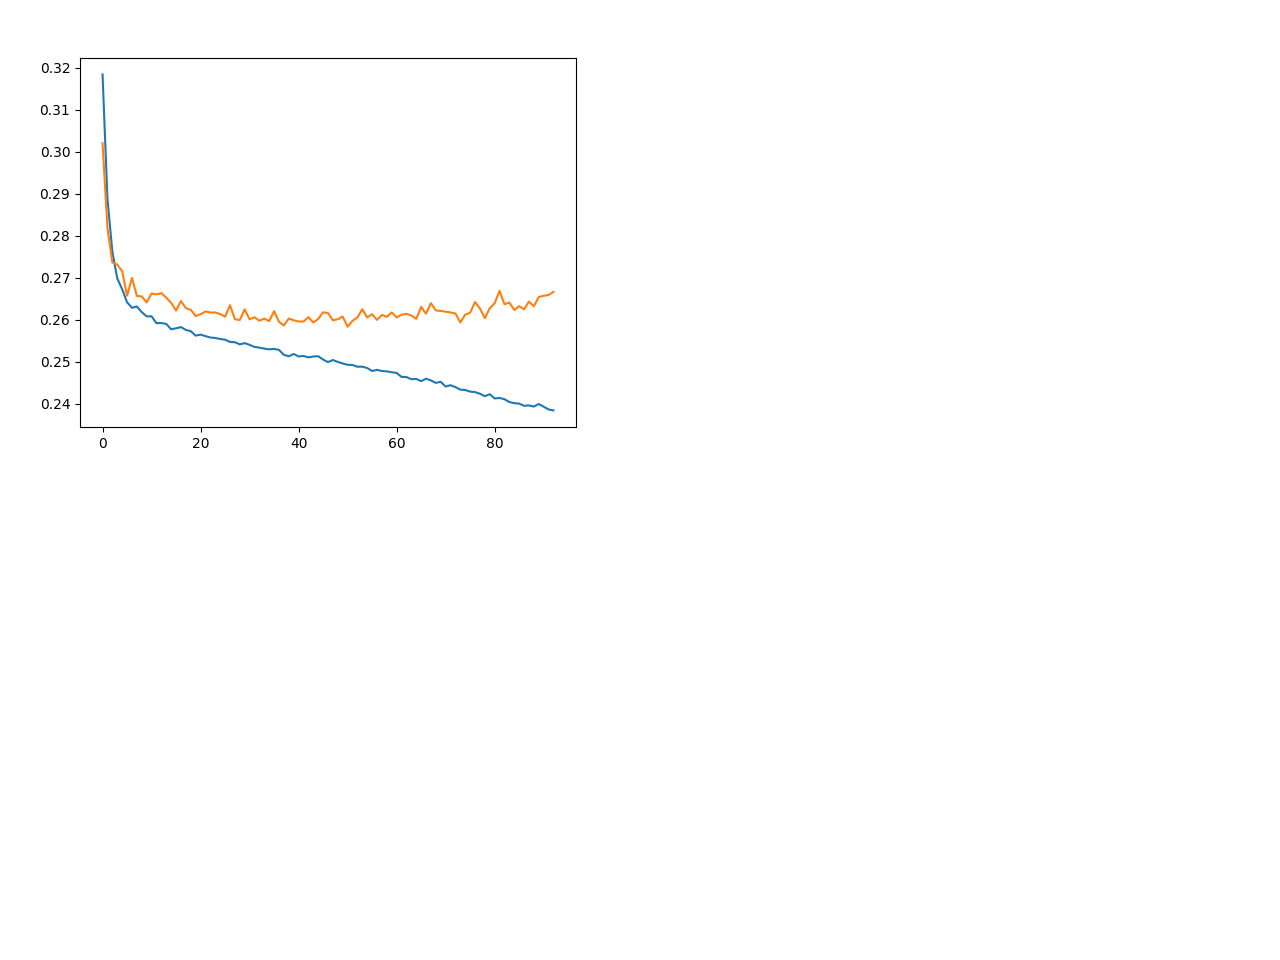

Iter 0, Learning rate 0.001000


KeyboardInterrupt: 

In [49]:
import matplotlib.pyplot as plt
%matplotlib notebook

# device = torch.device('cpu')
device = torch.device('cuda')
# model = Net().to(device)
# model = NotHitConnect().to(device)
model = ConvNet().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, 
#                              weight_decay=5e-5,
                            )
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=.7)
train_losses = []
val_losses = []
model_pars = []

crit = torch.nn.MSELoss()
model.train()
epoch_bar = tqdm(range(250))

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()

last_lr = float('inf')

for epoch in epoch_bar:
    # k-fold validation
    
#     k = 5
#     n_samples = 1000
#     batch_size = 16
#     for i in range(k):
#         ltrain = []
#         lval = []
#         train_set, val_set = get_k_fold_sets(dataset_modified, k, i, n_samples)
#         train_loader, val_loader = DataLoader(train_set, batch_size, drop_last=True, shuffle=True), \
#                                     DataLoader(val_set, batch_size, drop_last=True)
    
    # Train
    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        label = data.y.to(device)
        loss = crit(output, label)
        loss.backward()
        loss_all += float(data.num_graphs * (loss.item()))
        optimizer.step()

    train_losses.append(loss_all / len(train_loader.dataset))
    model_pars.append(model.state_dict())

    # Validate
    with torch.no_grad():
        val_loss_all = 0 
        for val_batch in val_loader:
            val_data = val_batch.to(device)
            val_label = val_data.y
            out_val = model(val_data)
            val_loss = crit(out_val, val_data.y)
            val_loss_all += float(val_data.num_graphs * (val_loss.item()))
    val_losses.append(val_loss_all / len(val_loader.dataset))
    epoch_bar.set_description("Train: %.2e, val: %.2e" % (train_losses[-1], val_losses[-1]))

    if val_loss_all / len(val_loader.dataset) <= min(val_losses):
        best_model = model
#         torch.save(model.state_dict(), './GCN_active_only_' + str(labels) + '.torch')
#         torch.save(model, './GCN_active_only_' + str(labels) + '.torch')


#     plt.scatter(epoch, loss_all)
    ax.clear()
#     ax.plot(np.arange(epoch+1), train_losses)
    plt.plot(train_losses, label="Training")
    plt.plot(val_losses, label="Validation")
#     plt.yscale('log')
    fig.canvas.draw()
    plt.pause(0.05)

    if scheduler.get_lr()[0] != last_lr:
        last_lr = scheduler.get_lr()[0]
        print('Iter %i, Learning rate %f' % (epoch, last_lr))

    scheduler.step()
    
plt.show()

In [50]:
np.min(val_losses), np.argmin(val_losses)

(0.2582913488149643, 50)

In [344]:
np.min(train_losses[:150]), np.argmin(train_losses[:150])

(0.24292479248046875, 141)

In [130]:
from IceNet.dataloader import get_data_3d
_,y_reco,reco = get_data_3d('./input/oscNext_genie_level3_v01.03_pass2.140000.000001.hdf5', min_pulses=1, 
                            labels=['azimuth', 'zenith'],
                            reco_labels=['azimuth','zenith'],
                           )

KeyboardInterrupt: 

In [149]:
from matplotlib.colors import LogNorm

In [150]:
def get_bands(hist):
    sigma = .6827
    binc, xedges, yedges, _ = hist
    xbins = (xedges[1:] + xedges[:-1]) / 2
    ybins = (yedges[1:] + yedges[:-1]) / 2
    
    lower_band = []
    upper_band = []
    for sliice, x in zip(binc, xbins):
        cumulative = np.cumsum(sliice)
        total = np.sum(sliice)
        imax = np.argmin(np.abs(cumulative - total*(1+sigma)/2))
        imin = np.argmin(np.abs(cumulative - total*(1-sigma)/2))
        lower_band.append(ybins[imin])
        upper_band.append(ybins[imax])
    
    return xbins, lower_band, upper_band

In [151]:
def torch_to_numpy(x):
    return np.asarray(x.cpu().detach())

In [152]:
import vg

In [153]:
def cart2polar(x, y, z):
    phi = np.arctan2(y, x)
    phi += 2*np.pi if phi < 0 else 0
    theta = np.arctan2(np.sqrt(x**2+y**2), z)
    return [phi, theta]

<IPython.core.display.Javascript object>


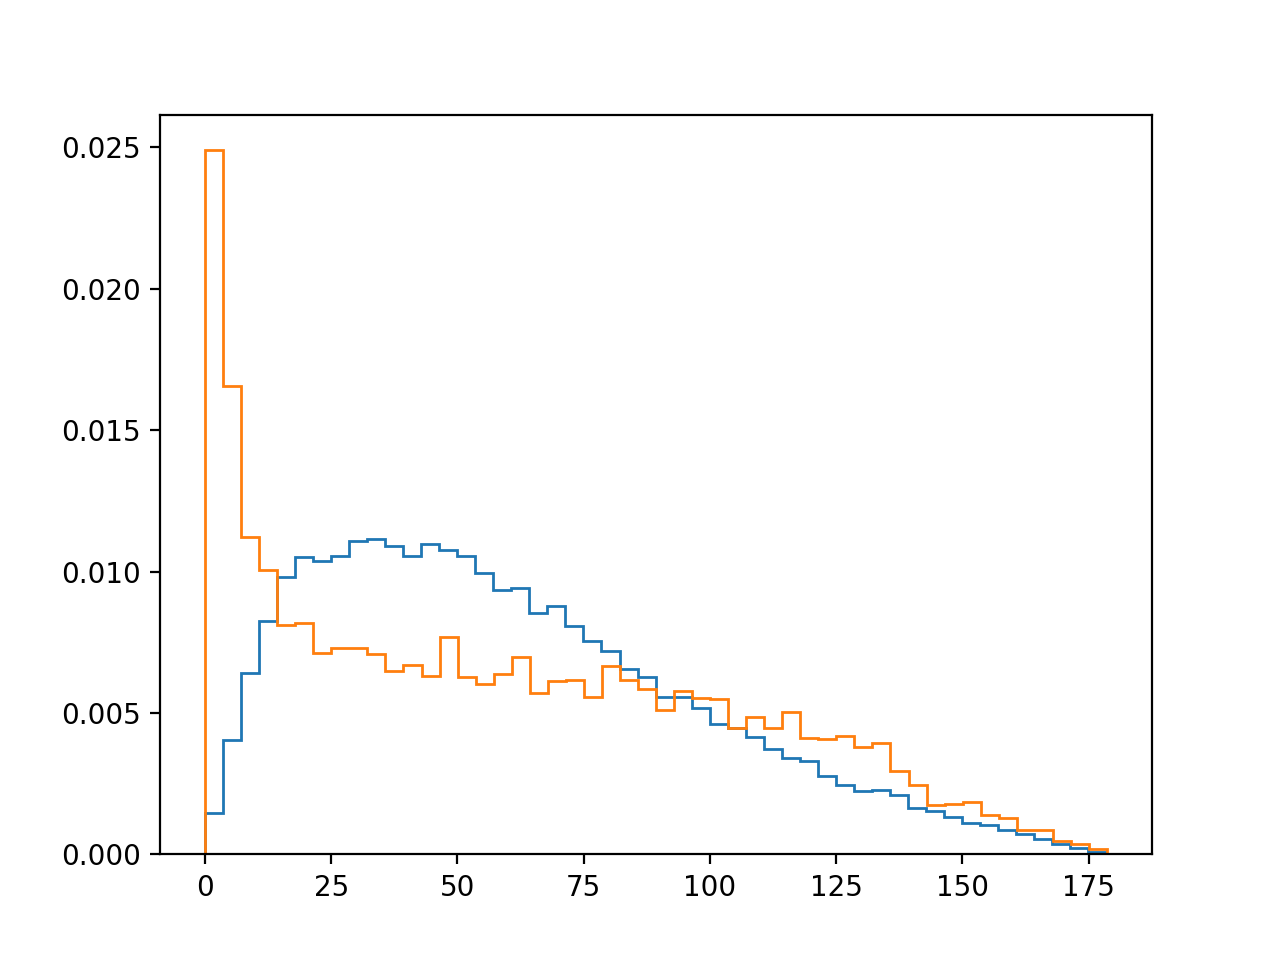

<IPython.core.display.Javascript object>


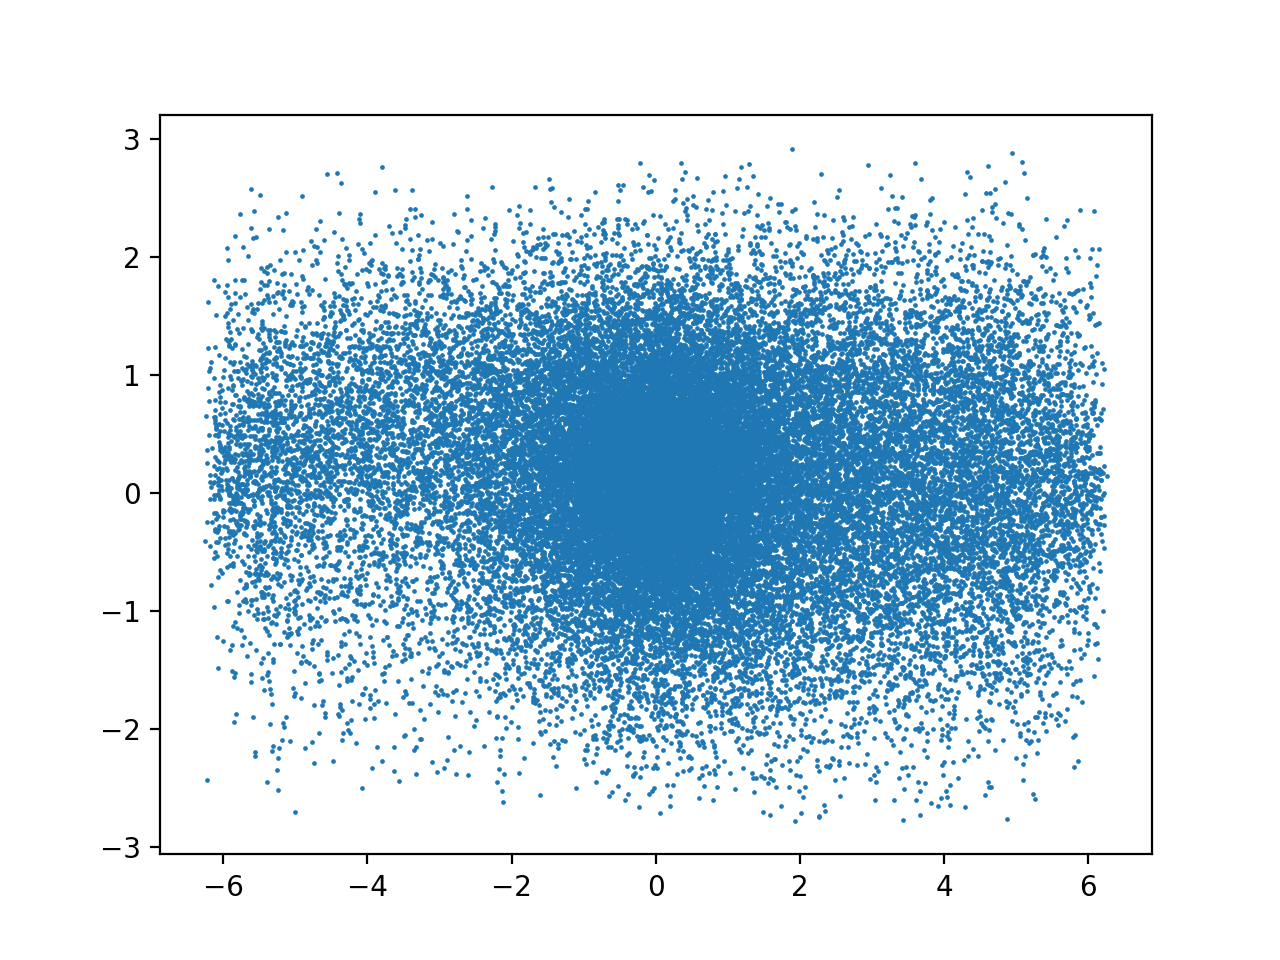

In [154]:
comb_loader = DataLoader(val_set+test_set, batch_size=1024, drop_last=True)
# model.train()
model_eval = model
with torch.no_grad():
#     plt.figure()
    model_eval.eval()
    gcn_pred = []
    gcn_truth = []
    for batch in test_loader:
        data = batch.to(device)
        gcn_pred.append(torch_to_numpy(model_eval(data)))
        gcn_truth.append(torch_to_numpy(data.y))
        
# gcn_pred = np.asarray(gcn_pred).flatten()
# gcn_truth = np.asarray(gcn_truth).flatten()


gcn_pred = np.asarray(gcn_pred).reshape(-1,2)
gcn_truth = np.asarray(gcn_truth).reshape(-1,2)


# Azmimuth and zenith
gcn_pred = np.asarray(gcn_pred).reshape(-1,3)
gcn_truth = np.asarray(gcn_truth).reshape(-1,3)

angles = [vg.angle(a, b) for a, b in zip(gcn_pred, gcn_truth)]

nan_mask = [False if np.isnan(r).any() else True for r in reco]

reco = reco[nan_mask]
y_reco = y_reco[nan_mask]
reco_az_spe = [polar2cart(1, *r) for r in reco]
reco_az_truth = [polar2cart(1, *r) for r in y_reco]

angles_spe = [vg.angle(np.array(a), np.array(b)) for a, b in zip(reco_az_spe, reco_az_truth)]

az_pred = np.array([cart2polar(*xyz) for xyz in gcn_pred])
az_truth = np.array([cart2polar(*xyz) for xyz in gcn_truth])

plt.figure()
plt.hist(angles, bins=50, histtype='step', density=True)
plt.hist(angles_spe, bins=50, histtype='step', density=True)
plt.show()

plt.figure()
diff = az_pred - az_truth
plt.scatter(diff[:,0], diff[:,1], s=.5)
plt.show()



zenith_pred = np.arctan2(gcn_pred[:,0],gcn_pred[:,1])
zenith_truth = np.arctan2(gcn_truth[:,0],gcn_truth[:,1])
    
# zenith_pred = np.arccos(gcn_pred)
# zenith_truth = np.arccos(gcn_truth)

#     line_range = [-1,1]
# line_range = [np.min(np.concatenate((zenith_pred, zenith_truth))),
#               np.max(np.concatenate((zenith_pred, zenith_truth)))]
# lin = np.linspace(*line_range, 100)
# plt.plot(lin, lin, c='r',  ls='--')

# hist = plt.hist2d(reco.reshape(-1), y_reco.reshape(-1), bins=[30,30])
# # hist = plt.hist2d(zenith_truth, zenith_pred, bins=[30,30])
# plt.colorbar()
# xx, lower, upper = get_bands(hist)
# plt.title('zenith')
# # plt.plot(xx, mean_band, c='b')
# plt.plot(xx, lower, c='b', ls=':')
# plt.plot(xx, upper, c='b', ls=':')

# test_reco = np.cos(test_reco)


# plt.scatter(reco, y_reco, c='orange', label='SPEFit', marker='x', s=.4)
# plt.scatter(gcn_pred, gcn_truth, c = 'b', label='Graph Neural Net', marker='+', s=10)
# plt.scatter(zenith_pred, zenith_truth,c = 'b', label='Graph Neural Net', marker='+', s=10)
# plt.scatter(test_reco[0,:], test_reco[1,:], c='orange', label='SPEFit', marker='x', s=.4)

# ntest = 2000
#     plt.scatter(test_reco[0,:,0], test_reco[1,:,0], c='orange', label='SPEFit', marker='x')
#     plt.scatter(test_reco[0,:,1], test_reco[1,:,1], c='orange', label='SPEFit', marker='x')
#     plt.scatter(np.cos(reco[9000:]), np.cos(y_reco[9000:]), c='orange', label='SPEFit', marker='x')


#     plt.scatter(gcn_pred[:,0], gcn_truth[:,0], label='Graph Neural Net', marker='+')
#     plt.scatter(gcn_pred[:,1], gcn_truth[:,1], label='Graph Neural Net', marker='+')
#     plt.scatter(gcn_pred[:,2], gcn_truth[:,2], label='Graph Neural Net', marker='+')
# plt.xlim(0,3.14)
# plt.ylim(0,3.14)
# plt.xlabel('Sim input')
# plt.ylabel('NN prediction')
# plt.legend()
# plt.show()

In [160]:
np.std(angles)

36.82441

In [155]:
np.arctan(gcn_pred[:,0] / gcn_pred[:,1])

array([ 0.8882483 , -1.1805103 , -1.4673054 , ..., -1.1142626 ,
       -0.046257  , -0.65032643], dtype=float32)

In [142]:
np.arctan(gcn_truth[:,0] / gcn_truth[:,1])

array([ 1.1262345 , -0.2557931 , -1.269148  , ...,  1.2959439 ,
       -0.20263767,  1.3802528 ], dtype=float32)

In [143]:
np.arcsin(gcn_truth[:,0])

array([ 1.1200734 ,  0.16795737, -1.0098027 , ...,  0.9851953 ,
        0.1846457 , -1.3076665 ], dtype=float32)

In [144]:

d = np.random.uniform(-np.pi,np.pi, 10000) - np.random.uniform(-np.pi,np.pi, 10000)

In [145]:
d_gnn = zenith_pred-zenith_truth

In [226]:
np.mean(d_gnn[~np.isnan(d_gnn)]), np.std(d_gnn[~np.isnan(d_gnn)])

(0.029562367, 0.55589217)

In [246]:
len(dd[np.isnan(dd)])/len(dd)

0.16880955982453485

In [248]:
len(dd)

13222

In [239]:
dd = reco-y_reco
# dd = test_reco[0]-test_reco[1]
# np.mean(dd[~np.isnan(dd)]), np.std(dd[~np.isnan(dd)])
np.mean(dd), np.std(dd)


(nan, nan)

In [227]:
len(zenith_pred)

4864

In [240]:
dd_test = np.copy(dd)
dd_test[np.isnan(dd_test)] = 4

<IPython.core.display.Javascript object>


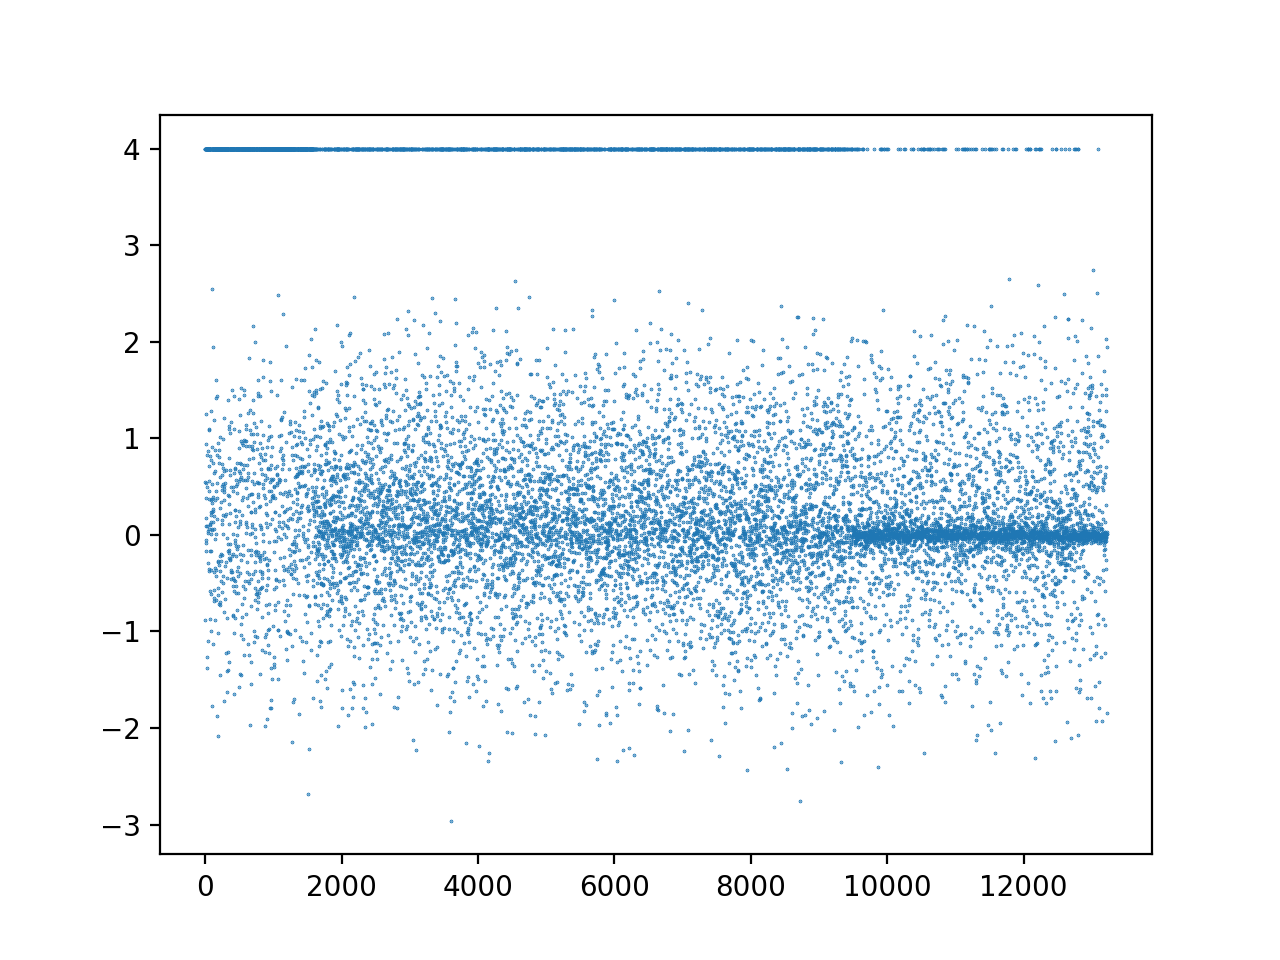

In [249]:
plt.figure()
plt.scatter(np.arange(len(dd_test)), dd_test, s=.1)
plt.show()

<IPython.core.display.Javascript object>


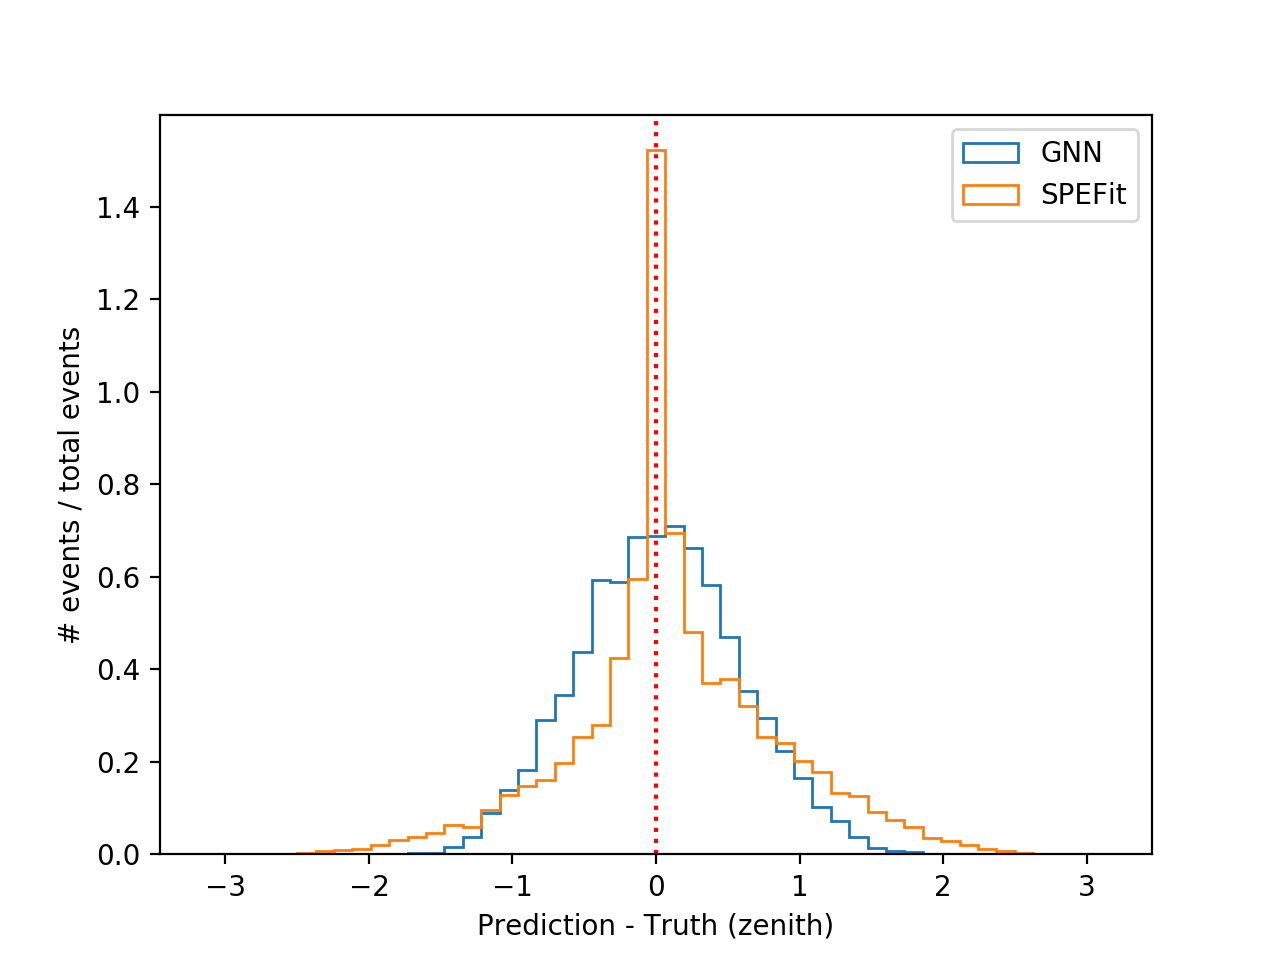

In [254]:
plt.figure()
bins = np.linspace(-np.pi,np.pi,50)
plt.hist(zenith_pred- zenith_truth, histtype='step', bins=bins, density=True, label='GNN')
# plt.hist(d, histtype='step', bins=30, density=True, label='random')
# plt.hist(test_reco[0]-test_reco[1], histtype='step', bins=bins, density=True, label='SPEFit')
plt.hist(dd, histtype='step', bins=bins, density=True, label='SPEFit')
# plt.xlim(-150,150)
plt.axvline(0, ls=':', c='r')
plt.xlabel('Prediction - Truth (zenith)')
plt.ylabel('# events / total events')
plt.legend()
plt.show()

In [ ]:
from scipy.stats import pearsonr
pearsonr((gcn_pred), gcn_truth)

In [ ]:
pearsonr(np.asarray([-350]* len(gcn_truth)+np.random.random(len(gcn_truth))), gcn_truth)

In [ ]:
np.random.random()

In [251]:
ww = torch_to_numpy(model_pars[0]['linear1.weight'])

<IPython.core.display.Javascript object>


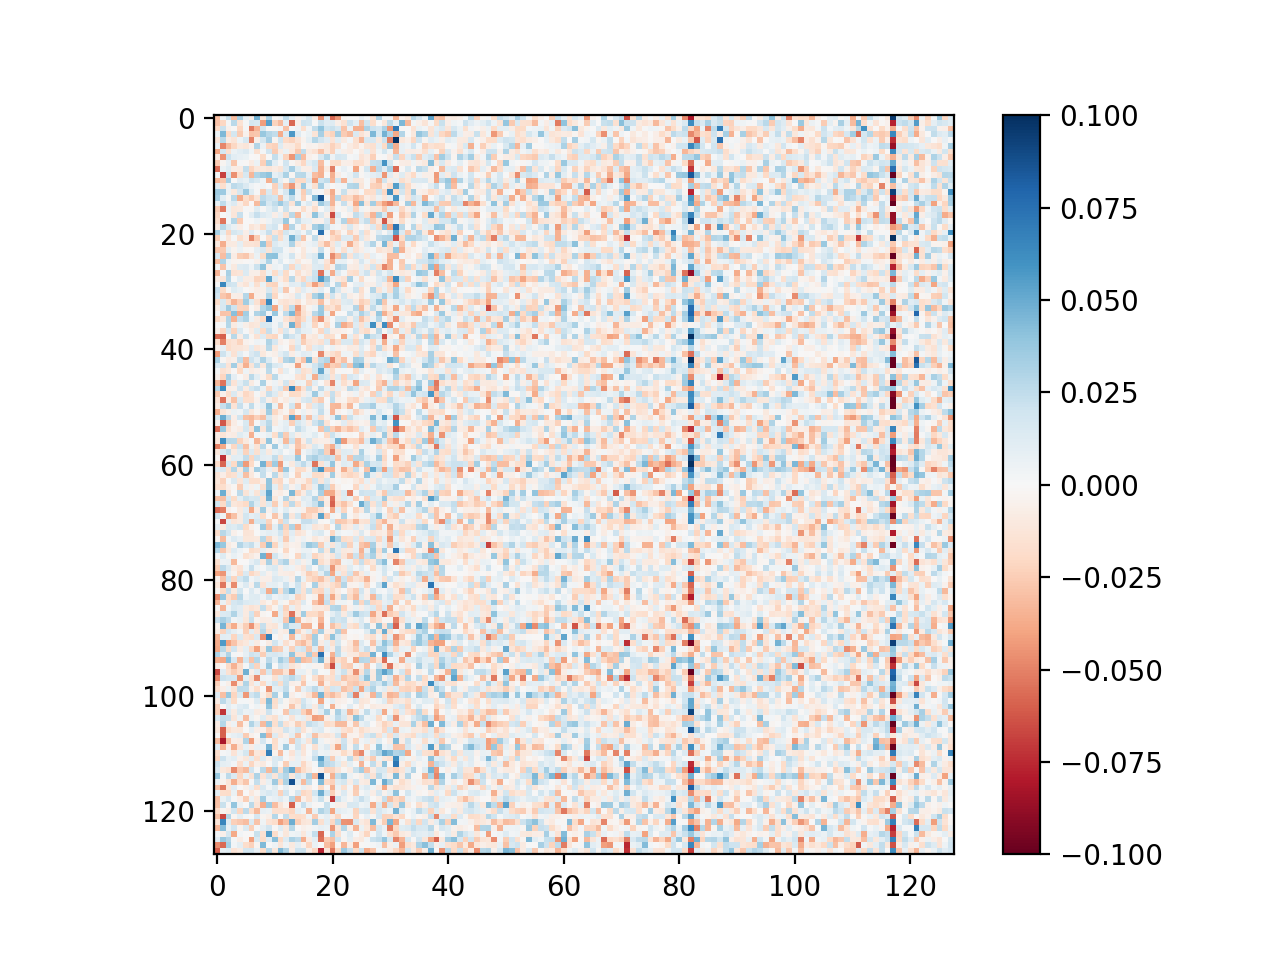

In [252]:
plt.figure()
plt.imshow(ww, cmap='RdBu', vmin=-.1, vmax=.1)
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


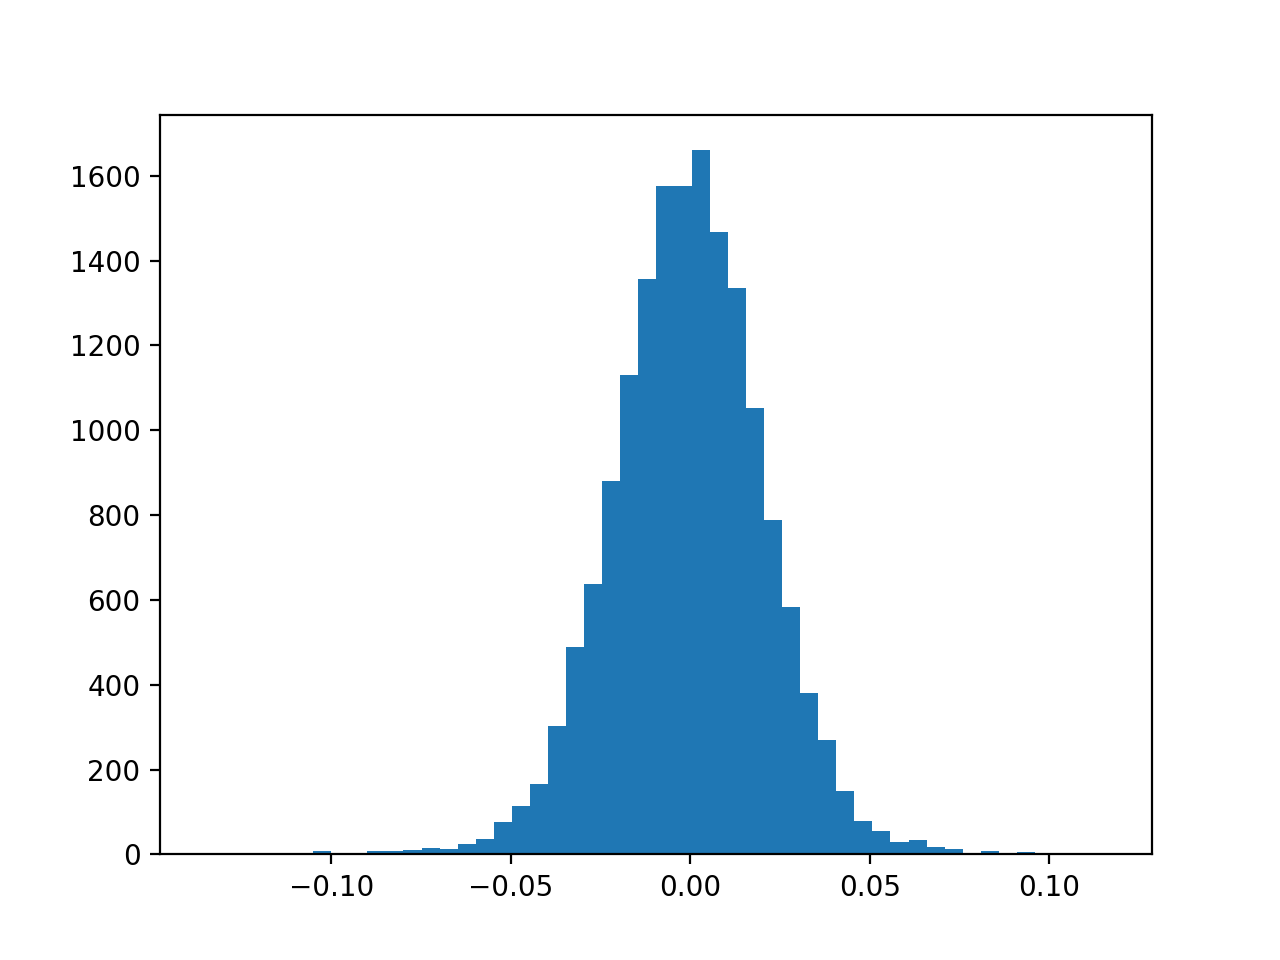

In [253]:
plt.figure()
plt.hist(ww.flatten(), bins=50)
plt.show()

In [194]:
list(model.children())

[SAGEConv(4, 64),
 SAGEConv(64, 64),
 Linear(in_features=64, out_features=64, bias=True),
 Linear(in_features=64, out_features=64, bias=True),
 Linear(in_features=64, out_features=64, bias=True),
 Linear(in_features=64, out_features=64, bias=True),
 Linear(in_features=64, out_features=64, bias=True),
 Dropout(p=0.3, inplace=False),
 Linear(in_features=64, out_features=1, bias=True)]